#  MACHINE LEARNING: Portugal Wine under Two Class approach for red and white classification using R and K fold cross-validation.
# Module 4: Solving project with dataset dffful

By: Hector Alvaro Rojas | Data Science, Visualizations and Applied Statistics | October 12, 2017<br>
Url: [http://www.arqmain.net]   &nbsp;&nbsp;&nbsp;|&nbsp;&nbsp;&nbsp;   GitHub: [https://github.com/arqmain]
<hr>

## I Introduction

We consider the original dataset without the variables "density" and "free.sulfor.dioxide".

<u><b><i>dfffull</i></b></u> keep all the register of the original database "df" but replace the upper outliers by its corresponding <i>Threshold</i>.


We consider outliers those points that have any predictor variable value to be outside of the limits constructed by boxplots. The following rule is applied:

* A predictor value is considered to be an upper outlier only if it is greater than <b>Threshold = Q3 + 1.5IQR</b>

Application of this rule oes not reduces the original datasize becouse it does not eliminate any register.  So, <i>dfffull</i></b></u> data size is the same as the original "df" 6497). 

## II Loading and the Data

In [117]:
# first remove ALL objects and close all possible connections
closeAllConnections()
rm(list = ls(all = TRUE)) # Does remove all inclusive hidden

# see your memory size
memory.size() 

In [1]:
# install packages and load libraries
ipak <- function(pkg){
    new.pkg <- pkg[!(pkg %in% installed.packages()[, "Package"])]
    if (length(new.pkg)) 
        install.packages(new.pkg, dependencies = c("Depends", "Suggests"))
    sapply(pkg, require, character.only = TRUE)
}
# usage
packages <- c("plyr", "dplyr", "caret")
ipak(packages)


Loading required package: plyr
Loading required package: dplyr

Attaching package: 'dplyr'

The following objects are masked from 'package:plyr':

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Loading required package: caret
Loading required package: lattice
Loading required package: ggplot2


plyr dplyr caret 
 TRUE  TRUE  TRUE

In [2]:
# define path location of datasets
wine1.url <- "http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv"
wine2.url <- "http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"

# read datasets
wine1 <- read.csv(wine1.url, header=TRUE, sep=';')
wine2 <- read.csv(wine2.url, header=TRUE, sep=';')

# create dataset base
paso <- rbind(cbind(wine1, Class='white'), cbind(wine2, Class='red'))

df= subset(paso, select=c('fixed.acidity', 'volatile.acidity', 'citric.acid', 'residual.sugar', 'chlorides' ,'total.sulfur.dioxide','pH', 'sulphates', 'alcohol', 'quality', 'Class'))
attach(df)
head(df)
rm("paso")

fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,total.sulfur.dioxide,pH,sulphates,alcohol,quality,Class
7.0,0.27,0.36,20.7,0.045,170,3.00,0.45,8.8,6,white
6.3,0.30,0.34,1.6,0.049,132,3.30,0.49,9.5,6,white
8.1,0.28,0.40,6.9,0.050,97,3.26,0.44,10.1,6,white
7.2,0.23,0.32,8.5,0.058,186,3.19,0.40,9.9,6,white
7.2,0.23,0.32,8.5,0.058,186,3.19,0.40,9.9,6,white
8.1,0.28,0.40,6.9,0.050,97,3.26,0.44,10.1,6,white


In [3]:
# verify response variable "Class" as factor. Remember, the class factor is always used for categorical variables.
df$Class <- as.factor(df$Class)

In [4]:
# get some information about the dataset
str(df)

'data.frame':	6497 obs. of  11 variables:
 $ fixed.acidity       : num  7 6.3 8.1 7.2 7.2 8.1 6.2 7 6.3 8.1 ...
 $ volatile.acidity    : num  0.27 0.3 0.28 0.23 0.23 0.28 0.32 0.27 0.3 0.22 ...
 $ citric.acid         : num  0.36 0.34 0.4 0.32 0.32 0.4 0.16 0.36 0.34 0.43 ...
 $ residual.sugar      : num  20.7 1.6 6.9 8.5 8.5 6.9 7 20.7 1.6 1.5 ...
 $ chlorides           : num  0.045 0.049 0.05 0.058 0.058 0.05 0.045 0.045 0.049 0.044 ...
 $ total.sulfur.dioxide: num  170 132 97 186 186 97 136 170 132 129 ...
 $ pH                  : num  3 3.3 3.26 3.19 3.19 3.26 3.18 3 3.3 3.22 ...
 $ sulphates           : num  0.45 0.49 0.44 0.4 0.4 0.44 0.47 0.45 0.49 0.45 ...
 $ alcohol             : num  8.8 9.5 10.1 9.9 9.9 10.1 9.6 8.8 9.5 11 ...
 $ quality             : int  6 6 6 6 6 6 6 6 6 6 ...
 $ Class               : Factor w/ 2 levels "white","red": 1 1 1 1 1 1 1 1 1 1 ...


In [7]:
#summarize full dataset by columns 
propmiss <- function(dataframe) {
	m <- sapply(dataframe, function(x) {
		data.frame(
			n=length(!is.na(x)), 
			nmiss=sum(is.na(x)), 
			propmiss=sum(is.na(x))/length(x),
			P25=round(quantile(x, 0.25, na.rm=TRUE),2),
			P75=round(quantile(x, 0.75, na.rm=TRUE),2),            
			IQR=round(IQR(x, na.rm=TRUE),2),
			Threshold= round(quantile(x, 0.75, na.rm=TRUE),2) + 1.5*round(IQR(x, na.rm=TRUE),2),            
			Minimum=round(min(x, na.rm=TRUE),2),
			Median=round(median(x, na.rm=TRUE),2),            
			Maximum=round(max(x, na.rm=TRUE),2),
			Range=round(max(x, na.rm=TRUE)-min(x, na.rm=TRUE),2),
			Mean=round(mean(x, na.rm=TRUE),2),
			StDev=round(sd(x, na.rm=TRUE),2)
		)
	})
	d <- data.frame(t(m))
	d <- sapply(d, unlist)
	d <- as.data.frame(d)
	d$variable <- row.names(d)
	row.names(d) <- NULL
	d <- cbind(d[ncol(d)],d[-ncol(d)])
	return(d[order(d$propmiss), ])
}

In [8]:
# summarize original df dataset
(summary1=propmiss(df[,-11])[,-(3:4)])

variable,n,P25,P75,IQR,Threshold,Minimum,Median,Maximum,Range,Mean,StDev
fixed.acidity,6497,6.40,7.70,1.30,9.650,3.80,7.00,15.90,12.10,7.22,1.30
volatile.acidity,6497,0.23,0.40,0.17,0.655,0.08,0.29,1.58,1.50,0.34,0.16
citric.acid,6497,0.25,0.39,0.14,0.600,0.00,0.31,1.66,1.66,0.32,0.15
residual.sugar,6497,1.80,8.10,6.30,17.550,0.60,3.00,65.80,65.20,5.44,4.76
chlorides,6497,0.04,0.06,0.03,0.105,0.01,0.05,0.61,0.60,0.06,0.04
total.sulfur.dioxide,6497,77.00,156.00,79.00,274.500,6.00,118.00,440.00,434.00,115.74,56.52
pH,6497,3.11,3.32,0.21,3.635,2.72,3.21,4.01,1.29,3.22,0.16
sulphates,6497,0.43,0.60,0.17,0.855,0.22,0.51,2.00,1.78,0.53,0.15
alcohol,6497,9.50,11.30,1.80,14.000,8.00,10.30,14.90,6.90,10.49,1.19
quality,6497,5.00,6.00,1.00,7.500,3.00,6.00,9.00,6.00,5.82,0.87


In [5]:
# r code to replace outliers by the threshold of each variable
library(mlr)

Loading required package: ParamHelpers

Attaching package: 'mlr'

The following object is masked from 'package:caret':

    train



In [6]:
# get some information about the dataset
str(dff)

'data.frame':	5040 obs. of  11 variables:
 $ fixed.acidity       : num  6.3 8.1 7.2 7.2 8.1 6.2 6.3 8.1 8.1 8.6 ...
 $ volatile.acidity    : num  0.3 0.28 0.23 0.23 0.28 0.32 0.3 0.22 0.27 0.23 ...
 $ citric.acid         : num  0.34 0.4 0.32 0.32 0.4 0.16 0.34 0.43 0.41 0.4 ...
 $ residual.sugar      : num  1.6 6.9 8.5 8.5 6.9 7 1.6 1.5 1.45 4.2 ...
 $ chlorides           : num  0.049 0.05 0.058 0.058 0.05 0.045 0.049 0.044 0.033 0.035 ...
 $ total.sulfur.dioxide: num  132 97 186 186 97 136 132 129 63 109 ...
 $ pH                  : num  3.3 3.26 3.19 3.19 3.26 3.18 3.3 3.22 2.99 3.14 ...
 $ sulphates           : num  0.49 0.44 0.4 0.4 0.44 0.47 0.49 0.45 0.56 0.53 ...
 $ alcohol             : num  9.5 10.1 9.9 9.9 10.1 9.6 9.5 11 12 9.7 ...
 $ quality             : int  6 6 6 6 6 6 6 6 5 5 ...
 $ Class               : Factor w/ 2 levels "white","red": 1 1 1 1 1 1 1 1 1 1 ...


In [9]:
dfffull <- capLargeValues(df, target = "Class",cols = c("fixed.acidity"),threshold = summary1[1,6])
dfffull <- capLargeValues(dfffull, target = "Class",cols = c("volatile.acidity"),threshold = summary1[2,6])
dfffull <- capLargeValues(dfffull, target = "Class",cols = c("citric.acid"),threshold = summary1[3,6])
dfffull <- capLargeValues(dfffull, target = "Class",cols = c("residual.sugar"),threshold = summary1[4,6])
dfffull <- capLargeValues(dfffull, target = "Class",cols = c("chlorides"),threshold = summary1[5,6])
dfffull <- capLargeValues(dfffull, target = "Class",cols = c("total.sulfur.dioxide"),threshold = summary1[6,6])
dfffull <- capLargeValues(dfffull, target = "Class",cols = c("pH"),threshold = summary1[7,6])
dfffull <- capLargeValues(dfffull, target = "Class",cols = c("sulphates"),threshold = summary1[8,6])
dfffull <- capLargeValues(dfffull, target = "Class",cols = c("alcohol"),threshold = summary1[9,6])
unloadNamespace("mlr")

In [12]:
# get some information about the dataset
str(dfffull)

'data.frame':	6497 obs. of  11 variables:
 $ fixed.acidity       : num  7 6.3 8.1 7.2 7.2 8.1 6.2 7 6.3 8.1 ...
 $ volatile.acidity    : num  0.27 0.3 0.28 0.23 0.23 0.28 0.32 0.27 0.3 0.22 ...
 $ citric.acid         : num  0.36 0.34 0.4 0.32 0.32 0.4 0.16 0.36 0.34 0.43 ...
 $ residual.sugar      : num  17.5 1.6 6.9 8.5 8.5 ...
 $ chlorides           : num  0.045 0.049 0.05 0.058 0.058 0.05 0.045 0.045 0.049 0.044 ...
 $ total.sulfur.dioxide: num  170 132 97 186 186 97 136 170 132 129 ...
 $ pH                  : num  3 3.3 3.26 3.19 3.19 3.26 3.18 3 3.3 3.22 ...
 $ sulphates           : num  0.45 0.49 0.44 0.4 0.4 0.44 0.47 0.45 0.49 0.45 ...
 $ alcohol             : num  8.8 9.5 10.1 9.9 9.9 10.1 9.6 8.8 9.5 11 ...
 $ quality             : int  6 6 6 6 6 6 6 6 6 6 ...
 $ Class               : Factor w/ 2 levels "white","red": 1 1 1 1 1 1 1 1 1 1 ...


In [13]:
# summarize dfffull dataset
(summary=propmiss(dfffull[,-11])[,-(3:4)][,-6])

variable,n,P25,P75,IQR,Minimum,Median,Maximum,Range,Mean,StDev
fixed.acidity,6497,6.40,7.70,1.30,3.80,7.00,9.65,5.85,7.14,1.07
volatile.acidity,6497,0.23,0.40,0.17,0.08,0.29,0.66,0.58,0.33,0.14
citric.acid,6497,0.25,0.39,0.14,0.00,0.31,0.60,0.60,0.31,0.13
residual.sugar,6497,1.80,8.10,6.30,0.60,3.00,17.55,16.95,5.41,4.61
chlorides,6497,0.04,0.06,0.03,0.01,0.05,0.10,0.10,0.05,0.02
total.sulfur.dioxide,6497,77.00,156.00,79.00,6.00,118.00,274.50,268.50,115.67,56.26
pH,6497,3.11,3.32,0.21,2.72,3.21,3.63,0.91,3.22,0.16
sulphates,6497,0.43,0.60,0.17,0.22,0.51,0.86,0.64,0.53,0.13
alcohol,6497,9.50,11.30,1.80,8.00,10.30,14.00,6.00,10.49,1.19
quality,6497,5.00,6.00,1.00,3.00,6.00,9.00,6.00,5.82,0.87


In [14]:
# remove and dettach df dataset
rm("df")
detach("df")

In [15]:
# rename dff dataset as df dataset to use the already created R scripts
df <- dfffull

# remove dff dataset
rm("dfffull")

In [16]:
head(df)
str(df)

fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,total.sulfur.dioxide,pH,sulphates,alcohol,quality,Class
7.0,0.27,0.36,17.55,0.045,170,3.00,0.45,8.8,6,white
6.3,0.30,0.34,1.60,0.049,132,3.30,0.49,9.5,6,white
8.1,0.28,0.40,6.90,0.050,97,3.26,0.44,10.1,6,white
7.2,0.23,0.32,8.50,0.058,186,3.19,0.40,9.9,6,white
7.2,0.23,0.32,8.50,0.058,186,3.19,0.40,9.9,6,white
8.1,0.28,0.40,6.90,0.050,97,3.26,0.44,10.1,6,white


'data.frame':	6497 obs. of  11 variables:
 $ fixed.acidity       : num  7 6.3 8.1 7.2 7.2 8.1 6.2 7 6.3 8.1 ...
 $ volatile.acidity    : num  0.27 0.3 0.28 0.23 0.23 0.28 0.32 0.27 0.3 0.22 ...
 $ citric.acid         : num  0.36 0.34 0.4 0.32 0.32 0.4 0.16 0.36 0.34 0.43 ...
 $ residual.sugar      : num  17.5 1.6 6.9 8.5 8.5 ...
 $ chlorides           : num  0.045 0.049 0.05 0.058 0.058 0.05 0.045 0.045 0.049 0.044 ...
 $ total.sulfur.dioxide: num  170 132 97 186 186 97 136 170 132 129 ...
 $ pH                  : num  3 3.3 3.26 3.19 3.19 3.26 3.18 3 3.3 3.22 ...
 $ sulphates           : num  0.45 0.49 0.44 0.4 0.4 0.44 0.47 0.45 0.49 0.45 ...
 $ alcohol             : num  8.8 9.5 10.1 9.9 9.9 10.1 9.6 8.8 9.5 11 ...
 $ quality             : int  6 6 6 6 6 6 6 6 6 6 ...
 $ Class               : Factor w/ 2 levels "white","red": 1 1 1 1 1 1 1 1 1 1 ...


## III Getting train and test datasets

In [17]:
#stratified sampling to get the train and test dataset
set.seed(7) # Set Seed so that same sample can be reproduced in future also
# considering response variable as strata
data_part <- createDataPartition(y = df$Class,  p = 0.70, list = F)
testing <- df[-data_part,] # 30% data goes here
training <- df[data_part,] # 70% here

length(training$Class)
length(testing$Class)

# training$quality <- NULL
# testing$quality <- NULL

[1] 4549

[1] 1948

In [18]:
#taking a look of the train and test dataset by columns 
head(training)
head(testing)

,fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,total.sulfur.dioxide,pH,sulphates,alcohol,quality,Class
2,6.3,0.30,0.34,1.60,0.049,132,3.30,0.49,9.5,6,white
3,8.1,0.28,0.40,6.90,0.050,97,3.26,0.44,10.1,6,white
7,6.2,0.32,0.16,7.00,0.045,136,3.18,0.47,9.6,6,white
8,7.0,0.27,0.36,17.55,0.045,170,3.00,0.45,8.8,6,white
9,6.3,0.30,0.34,1.60,0.049,132,3.30,0.49,9.5,6,white
10,8.1,0.22,0.43,1.50,0.044,129,3.22,0.45,11.0,6,white


,fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,total.sulfur.dioxide,pH,sulphates,alcohol,quality,Class
1,7.0,0.270,0.36,17.55,0.045,170,3.00,0.45,8.8,6,white
4,7.2,0.230,0.32,8.50,0.058,186,3.19,0.40,9.9,6,white
5,7.2,0.230,0.32,8.50,0.058,186,3.19,0.40,9.9,6,white
6,8.1,0.280,0.40,6.90,0.050,97,3.26,0.44,10.1,6,white
18,6.2,0.655,0.48,1.20,0.029,75,3.33,0.39,12.8,8,white
20,6.5,0.310,0.14,7.50,0.044,133,3.22,0.50,9.5,5,white


In [19]:
# get some information about training dataset
str(training[,1:11])

'data.frame':	4549 obs. of  11 variables:
 $ fixed.acidity       : num  6.3 8.1 6.2 7 6.3 8.1 8.1 8.6 7.9 6.6 ...
 $ volatile.acidity    : num  0.3 0.28 0.32 0.27 0.3 0.22 0.27 0.23 0.18 0.16 ...
 $ citric.acid         : num  0.34 0.4 0.16 0.36 0.34 0.43 0.41 0.4 0.37 0.4 ...
 $ residual.sugar      : num  1.6 6.9 7 17.5 1.6 ...
 $ chlorides           : num  0.049 0.05 0.045 0.045 0.049 0.044 0.033 0.035 0.04 0.044 ...
 $ total.sulfur.dioxide: num  132 97 136 170 132 129 63 109 75 143 ...
 $ pH                  : num  3.3 3.26 3.18 3 3.3 3.22 2.99 3.14 3.18 3.54 ...
 $ sulphates           : num  0.49 0.44 0.47 0.45 0.49 0.45 0.56 0.53 0.63 0.52 ...
 $ alcohol             : num  9.5 10.1 9.6 8.8 9.5 11 12 9.7 10.8 12.4 ...
 $ quality             : int  6 6 6 6 6 6 5 5 5 7 ...
 $ Class               : Factor w/ 2 levels "white","red": 1 1 1 1 1 1 1 1 1 1 ...


In [20]:
# get some information about testing dataset
str(testing[,1:11])

'data.frame':	1948 obs. of  11 variables:
 $ fixed.acidity       : num  7 7.2 7.2 8.1 6.2 6.5 6.8 6.6 7.2 6.2 ...
 $ volatile.acidity    : num  0.27 0.23 0.23 0.28 0.655 0.31 0.26 0.27 0.32 0.12 ...
 $ citric.acid         : num  0.36 0.32 0.32 0.4 0.48 0.14 0.42 0.41 0.36 0.34 ...
 $ residual.sugar      : num  17.5 8.5 8.5 6.9 1.2 ...
 $ chlorides           : num  0.045 0.058 0.058 0.05 0.029 0.044 0.049 0.052 0.033 0.045 ...
 $ total.sulfur.dioxide: num  170 186 186 97 75 133 122 142 114 117 ...
 $ pH                  : num  3 3.19 3.19 3.26 3.33 3.22 3.47 3.42 3.1 3.42 ...
 $ sulphates           : num  0.45 0.4 0.4 0.44 0.39 0.5 0.48 0.47 0.71 0.51 ...
 $ alcohol             : num  8.8 9.9 9.9 10.1 12.8 9.5 10.5 10 12.3 9 ...
 $ quality             : int  6 6 6 6 8 5 8 6 7 6 ...
 $ Class               : Factor w/ 2 levels "white","red": 1 1 1 1 1 1 1 1 1 1 ...


In [21]:
# summarize training dataset
(summary=propmiss(training[,-11])[,-(3:4)][,-6])

variable,n,P25,P75,IQR,Minimum,Median,Maximum,Range,Mean,StDev
fixed.acidity,4549,6.40,7.60,1.20,4.20,7.00,9.65,5.45,7.13,1.05
volatile.acidity,4549,0.23,0.41,0.18,0.08,0.30,0.66,0.58,0.33,0.14
citric.acid,4549,0.24,0.39,0.15,0.00,0.31,0.60,0.60,0.31,0.13
residual.sugar,4549,1.80,8.10,6.30,0.60,2.90,17.55,16.95,5.39,4.61
chlorides,4549,0.04,0.06,0.03,0.01,0.05,0.10,0.10,0.05,0.02
total.sulfur.dioxide,4549,78.00,156.00,78.00,6.00,119.00,274.50,268.50,116.08,56.17
pH,4549,3.11,3.32,0.21,2.72,3.20,3.63,0.91,3.22,0.16
sulphates,4549,0.43,0.60,0.17,0.22,0.51,0.86,0.64,0.53,0.13
alcohol,4549,9.50,11.30,1.80,8.00,10.30,14.00,6.00,10.50,1.19
quality,4549,5.00,6.00,1.00,3.00,6.00,9.00,6.00,5.82,0.88


In [22]:
# summarize testing dataset
(summary=propmiss(testing[,-11])[,-(3:4)][,-6])

variable,n,P25,P75,IQR,Minimum,Median,Maximum,Range,Mean,StDev
fixed.acidity,1948,6.40,7.80,1.40,3.80,7.00,9.65,5.85,7.18,1.11
volatile.acidity,1948,0.23,0.40,0.17,0.08,0.29,0.66,0.57,0.33,0.14
citric.acid,1948,0.25,0.40,0.15,0.00,0.31,0.60,0.60,0.32,0.14
residual.sugar,1948,1.80,8.10,6.30,0.60,3.20,17.55,16.95,5.45,4.62
chlorides,1948,0.04,0.06,0.03,0.01,0.05,0.10,0.09,0.05,0.02
total.sulfur.dioxide,1948,75.75,155.00,79.25,6.00,117.00,274.50,268.50,114.72,56.46
pH,1948,3.10,3.32,0.22,2.79,3.21,3.63,0.84,3.22,0.16
sulphates,1948,0.43,0.60,0.17,0.25,0.50,0.86,0.60,0.53,0.13
alcohol,1948,9.50,11.30,1.80,8.00,10.30,14.00,6.00,10.47,1.20
quality,1948,5.00,6.00,1.00,3.00,6.00,9.00,6.00,5.82,0.85


## IV Building models
 
In this project I have considered CART, BOOSTED TREE C5.0, SVM, KNN and RF algorithms. I use "set.seed(7)" so that same sample can be reproduced in the future and also it ensures the results are directly comparable.

### 41 CART

In [23]:
## Control Resampling Technique: 10-fold CV
cvCtrl <- trainControl(method = "cv", number=10, summaryFunction = twoClassSummary, classProbs = TRUE)

In [24]:
## Construction Predictive Model
set.seed(1)
rpartTune <- train(Class ~ ., data = training, method = "rpart", tuneLength = 30, preProc = c("center", "scale"), metric = "ROC",  trControl = cvCtrl)

Loading required package: rpart


In [25]:
## train results
rpartTune

CART 

4549 samples
  10 predictor
   2 classes: 'white', 'red' 

Pre-processing: centered (10), scaled (10) 
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 4094, 4094, 4095, 4094, 4094, 4094, ... 
Resampling results across tuning parameters:

  cp          ROC        Sens       Spec     
  0.00000000  0.9877725  0.9842506  0.9607143
  0.02358374  0.9755545  0.9810453  0.9339286
  0.04716749  0.9758366  0.9755034  0.9357143
  0.07075123  0.8976229  0.9769645  0.8008929
  0.09433498  0.8976229  0.9769645  0.8008929
  0.11791872  0.8847864  0.9454657  0.8241071
  0.14150246  0.8847864  0.9454657  0.8241071
  0.16508621  0.8847864  0.9454657  0.8241071
  0.18866995  0.8847864  0.9454657  0.8241071
  0.21225369  0.8847864  0.9454657  0.8241071
  0.23583744  0.8847864  0.9454657  0.8241071
  0.25942118  0.8847864  0.9454657  0.8241071
  0.28300493  0.8847864  0.9454657  0.8241071
  0.30658867  0.8847864  0.9454657  0.8241071
  0.33017241  0.8847864  0.9454657  0.8241071
  0

In [26]:
rpartTune$bestTune

cp
0


In [27]:
head(rpartTune$results)

cp,ROC,Sens,Spec,ROCSD,SensSD,SpecSD
0.00000000,0.9877725,0.9842506,0.9607143,0.007806591,0.011841261,0.01344237
0.02358374,0.9755545,0.9810453,0.9339286,0.006364581,0.009444961,0.03319487
0.04716749,0.9758366,0.9755034,0.9357143,0.007139131,0.010662646,0.03440044
0.07075123,0.8976229,0.9769645,0.8008929,0.034410621,0.013975560,0.04649911
0.09433498,0.8976229,0.9769645,0.8008929,0.034410621,0.013975560,0.04649911
0.11791872,0.8847864,0.9454657,0.8241071,0.025983959,0.012820212,0.06114605


In [28]:
(rpartTune$results)[1,]

cp,ROC,Sens,Spec,ROCSD,SensSD,SpecSD
0,0.9877725,0.9842506,0.9607143,0.007806591,0.01184126,0.01344237


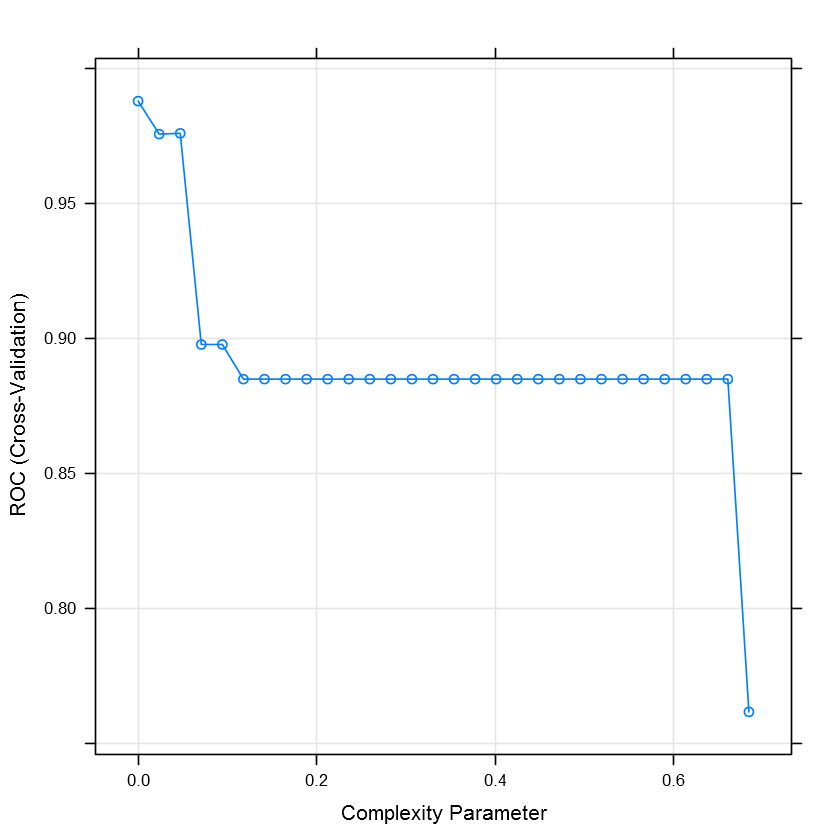

In [29]:
## Plot train tune
plot(rpartTune)

In [30]:
## Test Set Results   
rpartPred <- predict(rpartTune, testing)
confusionMatrix(rpartPred, testing$Class)

Confusion Matrix and Statistics

          Reference
Prediction white  red
     white  1444   23
     red      25  456
                                          
               Accuracy : 0.9754          
                 95% CI : (0.9675, 0.9818)
    No Information Rate : 0.7541          
    P-Value [Acc > NIR] : <2e-16          
                                          
                  Kappa : 0.9337          
 Mcnemar's Test P-Value : 0.8852          
                                          
            Sensitivity : 0.9830          
            Specificity : 0.9520          
         Pos Pred Value : 0.9843          
         Neg Pred Value : 0.9480          
             Prevalence : 0.7541          
         Detection Rate : 0.7413          
   Detection Prevalence : 0.7531          
      Balanced Accuracy : 0.9675          
                                          
       'Positive' Class : white           
                                          

In [31]:
## Predicting Class Probabilities
rpartProbs <- predict(rpartTune, testing, type = "prob")
head(rpartProbs)

,white,red
1,0.9977034,0.002296588
4,0.9977034,0.002296588
5,0.9977034,0.002296588
6,0.9977034,0.002296588
18,0.9977034,0.002296588
20,0.9977034,0.002296588


In [32]:
# variable importance
cart.imp = varImp ( rpartTune , scale = F )
cart.imp

rpart variable importance

                     Overall
total.sulfur.dioxide 1496.36
chlorides            1154.94
volatile.acidity      928.97
sulphates             571.42
fixed.acidity         373.67
residual.sugar        175.68
pH                    153.39
citric.acid            68.99
alcohol                23.74
quality                14.32

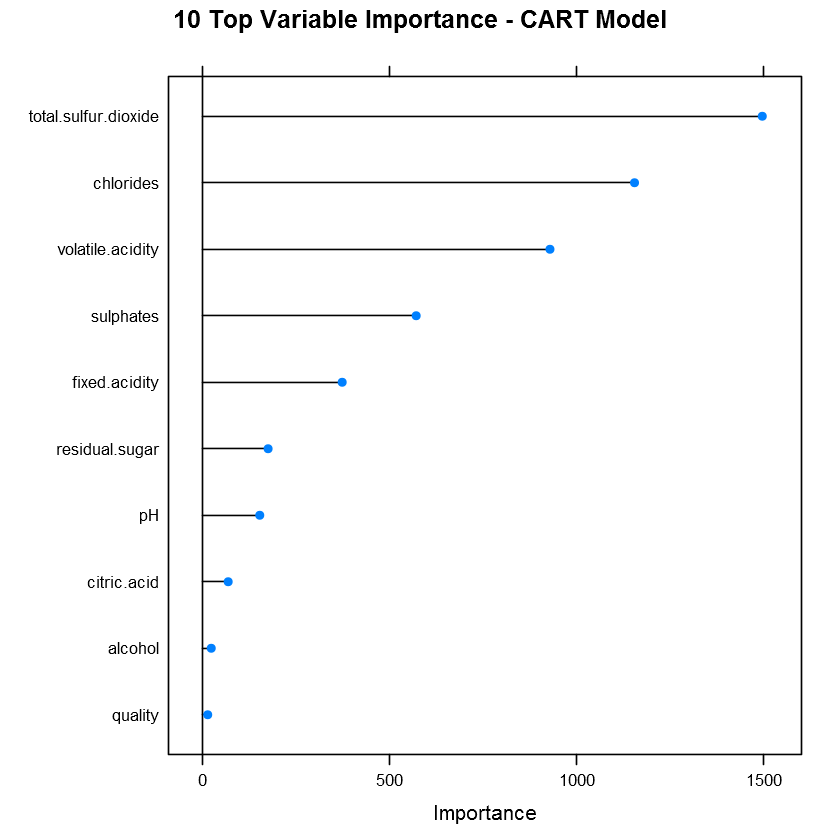

In [33]:
## Graphic variable importance
# dev.new()
plot(cart.imp, top=10, main="10 Top Variable Importance - CART Model")

### 42 Boosted Trees C5.0 (C5)

In [34]:
## Control Resampling Technique: 10-fold CV
cvCtrl <- trainControl(method = "cv", number=10, summaryFunction = twoClassSummary, classProbs = TRUE)

In [35]:
## Control Grid
grid <- expand.grid(.model = "tree", .trials = c(1,5,10,15,20), .winnow = FALSE)

In [36]:
## Construction Predictive Model
set.seed(1)
c5Tune <- train(Class ~ ., data = training, method = "C5.0", metric = "ROC", preProc = c("center", "scale"), tuneGrid = grid, trControl = cvCtrl)

Loading required package: C50


In [37]:
## train results
c5Tune

C5.0 

4549 samples
  10 predictor
   2 classes: 'white', 'red' 

Pre-processing: centered (10), scaled (10) 
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 4094, 4094, 4095, 4094, 4094, 4094, ... 
Resampling results across tuning parameters:

  trials  ROC        Sens       Spec     
   1      0.9922397  0.9912519  0.9723214
   5      0.9963528  0.9909587  0.9794643
  10      0.9977206  0.9927080  0.9830357
  15      0.9981071  0.9947496  0.9830357
  20      0.9985496  0.9947488  0.9848214

Tuning parameter 'model' was held constant at a value of tree
Tuning
 parameter 'winnow' was held constant at a value of FALSE
ROC was used to select the optimal model using  the largest value.
The final values used for the model were trials = 20, model = tree and winnow
 = FALSE.

In [38]:
c5Tune$bestTune

,trials,model,winnow
5,20,tree,FALSE


In [39]:
head(c5Tune$results)

model,winnow,trials,ROC,Sens,Spec,ROCSD,SensSD,SpecSD
tree,FALSE,1,0.9922397,0.9912519,0.9723214,0.004230720,0.004344831,0.01068946
tree,FALSE,5,0.9963528,0.9909587,0.9794643,0.005427020,0.004227257,0.01035269
tree,FALSE,10,0.9977206,0.9927080,0.9830357,0.002908482,0.004613340,0.01293873
tree,FALSE,15,0.9981071,0.9947496,0.9830357,0.002430698,0.004919078,0.01068946
tree,FALSE,20,0.9985496,0.9947488,0.9848214,0.002035723,0.005110279,0.01194191


In [40]:
(c5Tune$results)[5,]

,model,winnow,trials,ROC,Sens,Spec,ROCSD,SensSD,SpecSD
5,tree,FALSE,20,0.9985496,0.9947488,0.9848214,0.002035723,0.005110279,0.01194191


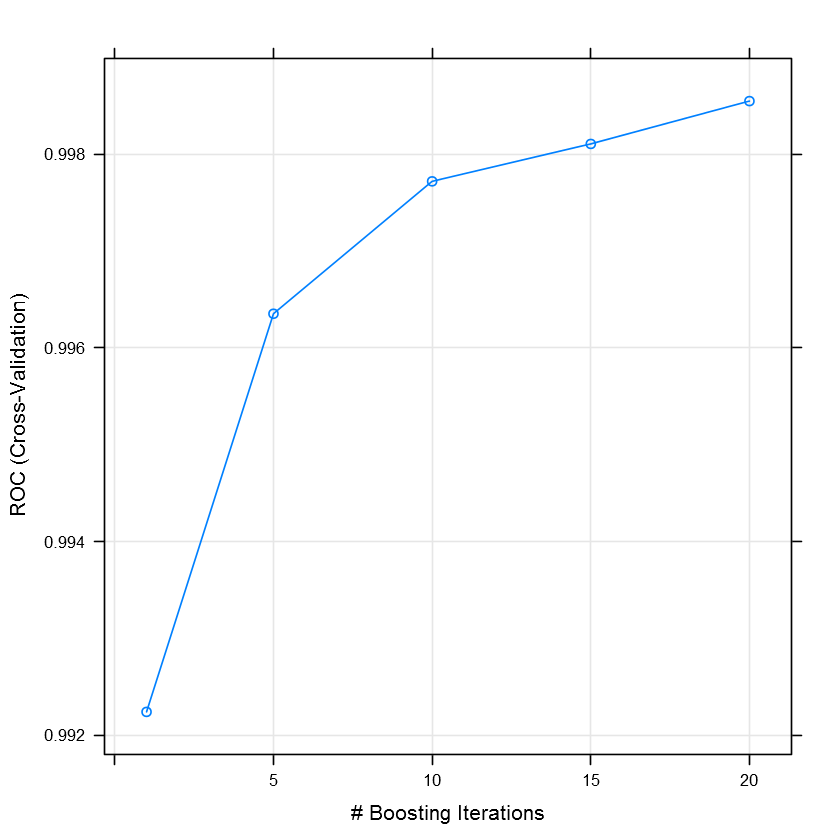

In [41]:
## Plot train tune
plot(c5Tune)

In [42]:
## Test Set Results
c5Pred <- predict(c5Tune, testing, preProc = c("center", "scale"))
confusionMatrix(c5Pred, testing$Class)

Confusion Matrix and Statistics

          Reference
Prediction white  red
     white  1468   12
     red       1  467
                                          
               Accuracy : 0.9933          
                 95% CI : (0.9886, 0.9964)
    No Information Rate : 0.7541          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.9819          
 Mcnemar's Test P-Value : 0.005546        
                                          
            Sensitivity : 0.9993          
            Specificity : 0.9749          
         Pos Pred Value : 0.9919          
         Neg Pred Value : 0.9979          
             Prevalence : 0.7541          
         Detection Rate : 0.7536          
   Detection Prevalence : 0.7598          
      Balanced Accuracy : 0.9871          
                                          
       'Positive' Class : white           
                                          

In [43]:
## Predicting Class Probabilities
c5Probs <- predict(c5Tune, testing, preProc = c("center", "scale"), type = "prob")
head(c5Probs, 3)

,white,red
1,1,0
4,1,0
5,1,0


In [44]:
## variable importance
c5.imp = varImp ( c5Tune , scale = F)
c5.imp


C5.0 variable importance

                     Overall
chlorides             100.00
total.sulfur.dioxide  100.00
volatile.acidity      100.00
sulphates             100.00
residual.sugar         99.49
fixed.acidity          98.48
alcohol                98.00
pH                     95.60
citric.acid            85.73
quality                27.50

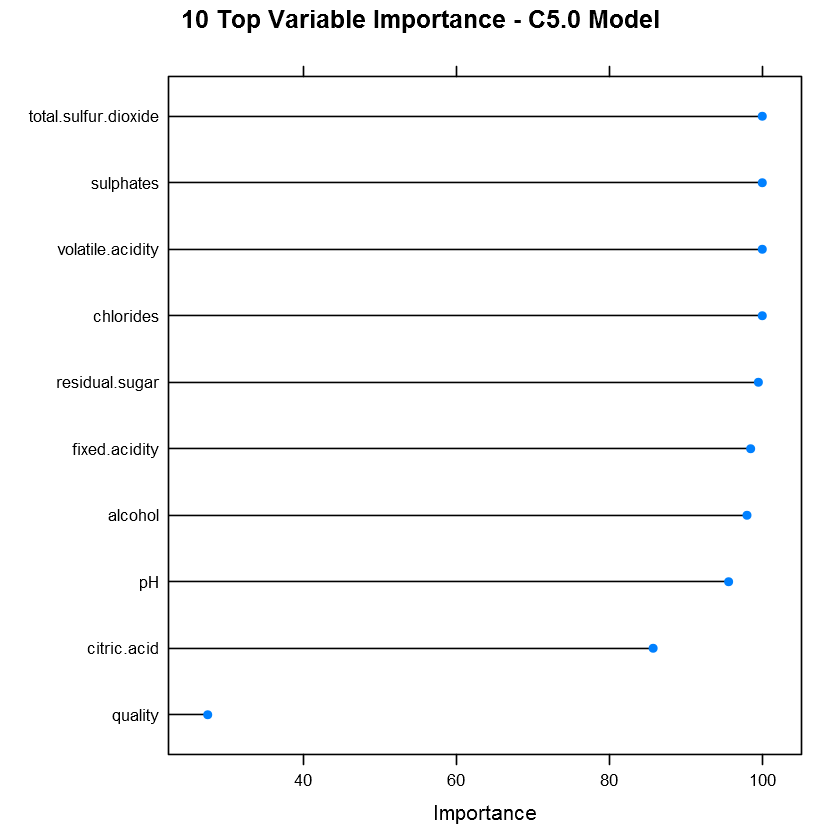

In [45]:
## Graphic variable importance
#dev.new()
plot(c5.imp, top=10, main="10 Top Variable Importance - C5.0 Model")

### 43 Support Vector Machines (SVM)

In [46]:
## Control Resampling Technique: 10-fold CV
cvCtrl <- trainControl(method = "cv", number=10, summaryFunction = twoClassSummary, classProbs = TRUE)

In [47]:
## Construction Predictive Model
set.seed(1)
svmTune <- train(Class ~ ., data = training, method = "svmRadial", tuneLength = 9, preProc = c("center", "scale"), metric = "ROC", trControl = cvCtrl)

Loading required package: kernlab

Attaching package: 'kernlab'

The following object is masked from 'package:ggplot2':

    alpha



In [48]:
## train results
svmTune

Support Vector Machines with Radial Basis Function Kernel 

4549 samples
  10 predictor
   2 classes: 'white', 'red' 

Pre-processing: centered (10), scaled (10) 
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 4094, 4094, 4095, 4094, 4094, 4094, ... 
Resampling results across tuning parameters:

  C      ROC        Sens       Spec     
   0.25  0.9978358  0.9959175  0.9857143
   0.50  0.9980206  0.9965006  0.9866071
   1.00  0.9980201  0.9965006  0.9866071
   2.00  0.9983220  0.9967922  0.9875000
   4.00  0.9987257  0.9973752  0.9857143
   8.00  0.9989707  0.9976668  0.9866071
  16.00  0.9991870  0.9970837  0.9821429
  32.00  0.9990931  0.9967922  0.9794643
  64.00  0.9990853  0.9970837  0.9803571

Tuning parameter 'sigma' was held constant at a value of 0.08802895
ROC was used to select the optimal model using  the largest value.
The final values used for the model were sigma = 0.08802895 and C = 16.

In [49]:
svmTune$bestTune

,sigma,C
7,0.08802895,16


In [50]:
head(svmTune$results)

sigma,C,ROC,Sens,Spec,ROCSD,SensSD,SpecSD
0.08802895,0.25,0.9978358,0.9959175,0.9857143,0.003002879,0.004599240,0.01048025
0.08802895,0.50,0.9980206,0.9965006,0.9866071,0.002706658,0.004516477,0.01208934
0.08802895,1.00,0.9980201,0.9965006,0.9866071,0.002587960,0.004516477,0.01208934
0.08802895,2.00,0.9983220,0.9967922,0.9875000,0.002212474,0.003490356,0.01129385
0.08802895,4.00,0.9987257,0.9973752,0.9857143,0.001670008,0.002151339,0.01276643
0.08802895,8.00,0.9989707,0.9976668,0.9866071,0.001331752,0.002299981,0.01347528


In [51]:
(svmTune$results)[7,]

,sigma,C,ROC,Sens,Spec,ROCSD,SensSD,SpecSD
7,0.08802895,16,0.999187,0.9970837,0.9821429,0.000970579,0.003073157,0.01330993


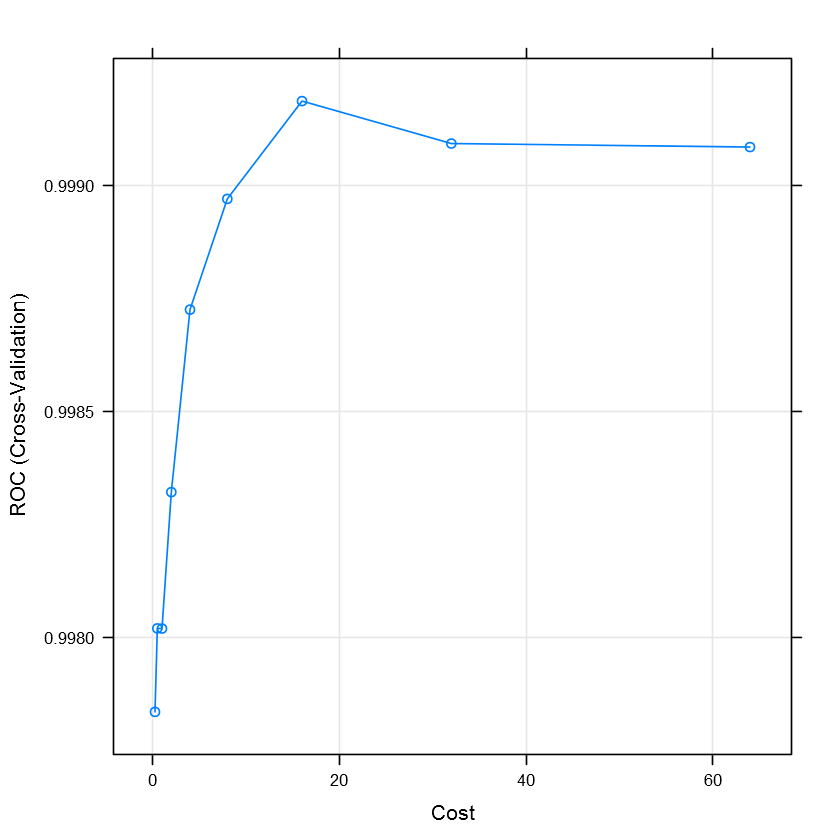

In [52]:
## Plot train tune
plot(svmTune)

In [53]:
## Test Set Results
svmPred <- predict(svmTune, testing, preProc = c("center", "scale"))
confusionMatrix(svmPred, testing$Class)

Confusion Matrix and Statistics

          Reference
Prediction white  red
     white  1462   10
     red       7  469
                                          
               Accuracy : 0.9913          
                 95% CI : (0.9861, 0.9949)
    No Information Rate : 0.7541          
    P-Value [Acc > NIR] : <2e-16          
                                          
                  Kappa : 0.9764          
 Mcnemar's Test P-Value : 0.6276          
                                          
            Sensitivity : 0.9952          
            Specificity : 0.9791          
         Pos Pred Value : 0.9932          
         Neg Pred Value : 0.9853          
             Prevalence : 0.7541          
         Detection Rate : 0.7505          
   Detection Prevalence : 0.7556          
      Balanced Accuracy : 0.9872          
                                          
       'Positive' Class : white           
                                          

In [54]:
## Predicting Class Probabilities
svmProbs <- predict(svmTune, testing, preProc = c("center", "scale"), type = "prob")
head(svmProbs, 3)

white,red
0.9999630,3.702439e-05
0.9997974,2.025978e-04
0.9997974,2.025978e-04


In [55]:
## variable importance
svm.imp = varImp ( svmTune , scale = F)
svm.imp


ROC curve variable importance

                     Importance
total.sulfur.dioxide     0.9517
chlorides                0.9477
volatile.acidity         0.9080
sulphates                0.8279
fixed.acidity            0.7739
pH                       0.7317
residual.sugar           0.6731
citric.acid              0.6175
quality                  0.5858
alcohol                  0.5123

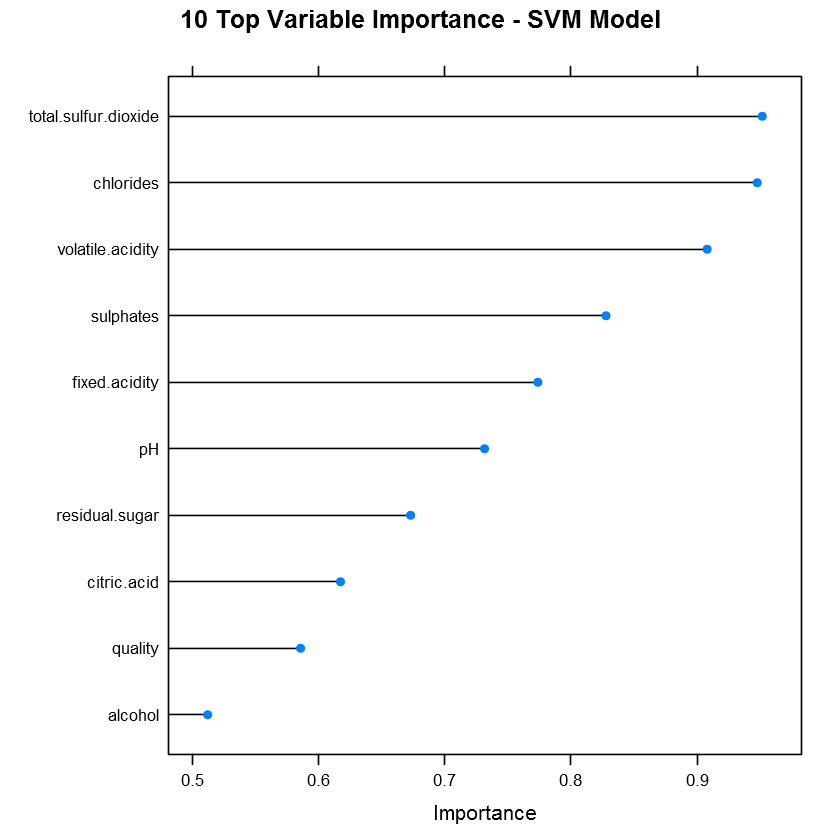

In [56]:
## Graphic variable importance
#dev.new()
plot(svm.imp, top=10, main="10 Top Variable Importance - SVM Model")

### 44 K-Nearest Neighbors (KNN)

In [57]:
## Control Resampling Technique: 10-fold CV
cvCtrl <- trainControl(method = "cv", number=10, summaryFunction = twoClassSummary, classProbs = TRUE)

In [58]:
## Construction Predictive Model
set.seed(1)
knnTune <- train ( Class ~ ., data = training, method = "knn", tuneLength = 10, preProc = c("center", "scale"), metric= "ROC", trControl = cvCtrl)

In [59]:
## train results
knnTune

k-Nearest Neighbors 

4549 samples
  10 predictor
   2 classes: 'white', 'red' 

Pre-processing: centered (10), scaled (10) 
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 4094, 4094, 4095, 4094, 4094, 4094, ... 
Resampling results across tuning parameters:

  k   ROC        Sens       Spec     
   5  0.9945954  0.9944589  0.9875000
   7  0.9952931  0.9932928  0.9857143
   9  0.9962396  0.9930004  0.9857143
  11  0.9962422  0.9924173  0.9866071
  13  0.9962436  0.9927097  0.9875000
  15  0.9963594  0.9938758  0.9857143
  17  0.9971910  0.9938758  0.9857143
  19  0.9971897  0.9935843  0.9857143
  21  0.9971897  0.9935843  0.9839286
  23  0.9976062  0.9935843  0.9848214

ROC was used to select the optimal model using  the largest value.
The final value used for the model was k = 23.

In [60]:
knnTune$bestTune

,k
10,23


In [61]:
head(knnTune$results)

k,ROC,Sens,Spec,ROCSD,SensSD,SpecSD
5,0.9945954,0.9944589,0.9875000,0.006074232,0.005574302,0.01205265
7,0.9952931,0.9932928,0.9857143,0.005261859,0.005505714,0.01129385
9,0.9962396,0.9930004,0.9857143,0.004544567,0.004801466,0.01205265
11,0.9962422,0.9924173,0.9866071,0.004571676,0.005358855,0.01133300
13,0.9962436,0.9927097,0.9875000,0.004567931,0.005366525,0.01205265
15,0.9963594,0.9938758,0.9857143,0.004283248,0.005903249,0.01205265


In [62]:
(knnTune$results)[10,]

,k,ROC,Sens,Spec,ROCSD,SensSD,SpecSD
10,23,0.9976062,0.9935843,0.9848214,0.003939684,0.005798231,0.01266193


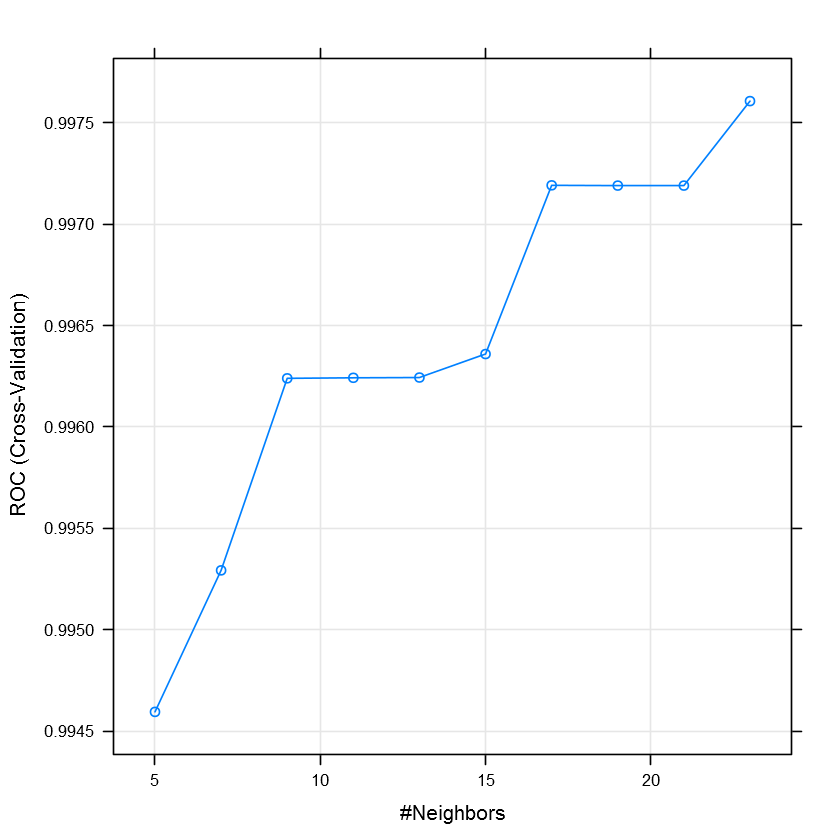

In [63]:
## Plot train tune
plot(knnTune)

In [64]:
## Test Set Results
knnPred <- predict(knnTune, testing, preProc = c("center", "scale"))
confusionMatrix(knnPred, testing$Class)

Confusion Matrix and Statistics

          Reference
Prediction white  red
     white  1460   12
     red       9  467
                                          
               Accuracy : 0.9892          
                 95% CI : (0.9836, 0.9933)
    No Information Rate : 0.7541          
    P-Value [Acc > NIR] : <2e-16          
                                          
                  Kappa : 0.9709          
 Mcnemar's Test P-Value : 0.6625          
                                          
            Sensitivity : 0.9939          
            Specificity : 0.9749          
         Pos Pred Value : 0.9918          
         Neg Pred Value : 0.9811          
             Prevalence : 0.7541          
         Detection Rate : 0.7495          
   Detection Prevalence : 0.7556          
      Balanced Accuracy : 0.9844          
                                          
       'Positive' Class : white           
                                          

In [65]:
## Predicting Class Probabilities
knnProbs <- predict(knnTune, testing, preProc = c("center", "scale"), type = "prob")
head(knnProbs, 3)

white,red
1,0
1,0
1,0


In [66]:
## variable importance
knn.imp = varImp ( knnTune , scale = F)
knn.imp

ROC curve variable importance

                     Importance
total.sulfur.dioxide     0.9517
chlorides                0.9477
volatile.acidity         0.9080
sulphates                0.8279
fixed.acidity            0.7739
pH                       0.7317
residual.sugar           0.6731
citric.acid              0.6175
quality                  0.5858
alcohol                  0.5123

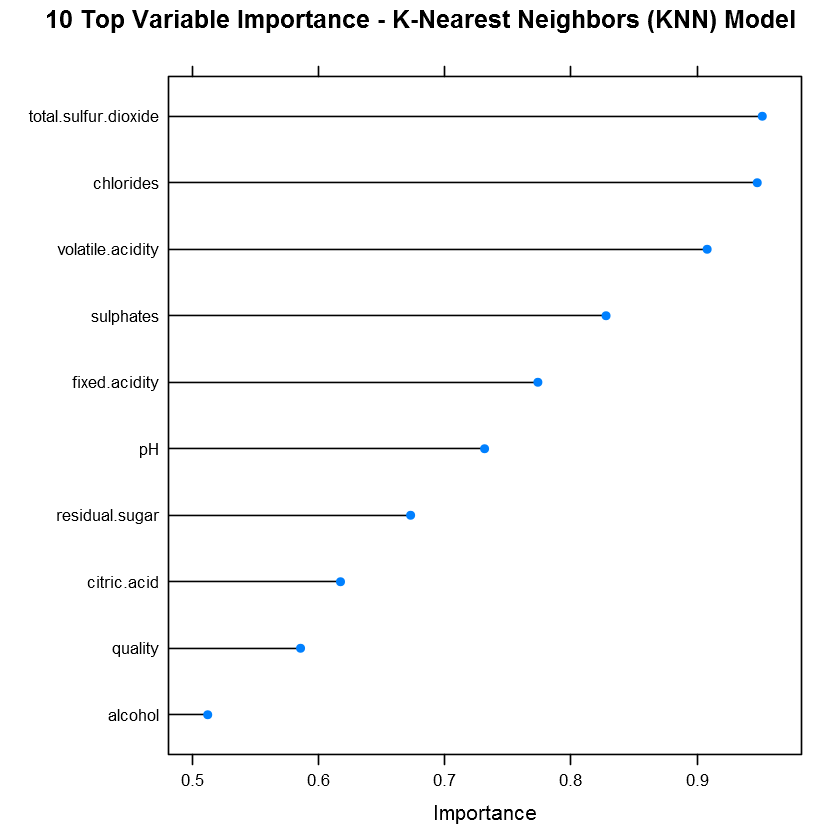

In [67]:
## Graphic variable importance
#dev.new()
plot(knn.imp, top=10, main="10 Top Variable Importance - K-Nearest Neighbors (KNN) Model")

### 45 Random Forest (RF)

In [68]:
## Control Resampling Technique: 10-fold CV
cvCtrl <- trainControl(method = "cv", number=10, summaryFunction = twoClassSummary, classProbs = TRUE, search="grid")

In [69]:
## Construction Predictive Model
set.seed(1)
rfGrid <- expand.grid ( .mtry = c (1:6 ) )
rfTune <- train ( Class ~ ., data = training, method = "rf", tuneGrid = rfGrid, ntree = 1000, preProc = c("center", "scale"), metric= "ROC", trControl = cvCtrl)

Loading required package: randomForest
randomForest 4.6-12
Type rfNews() to see new features/changes/bug fixes.

Attaching package: 'randomForest'

The following object is masked from 'package:ggplot2':

    margin

The following object is masked from 'package:dplyr':

    combine



In [70]:
## train results
rfTune

Random Forest 

4549 samples
  10 predictor
   2 classes: 'white', 'red' 

Pre-processing: centered (10), scaled (10) 
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 4094, 4094, 4095, 4094, 4094, 4094, ... 
Resampling results across tuning parameters:

  mtry  ROC        Sens       Spec     
  1     0.9988502  0.9982499  0.9821429
  2     0.9991128  0.9976668  0.9821429
  3     0.9991651  0.9964998  0.9848214
  4     0.9989841  0.9964998  0.9839286
  5     0.9985336  0.9962082  0.9839286
  6     0.9987927  0.9956251  0.9830357

ROC was used to select the optimal model using  the largest value.
The final value used for the model was mtry = 3.

In [71]:
rfTune$bestTune

,mtry
3,3


In [72]:
head(rfTune$results)

mtry,ROC,Sens,Spec,ROCSD,SensSD,SpecSD
1,0.9988502,0.9982499,0.9821429,0.002015290,0.003134370,0.011904762
2,0.9991128,0.9976668,0.9821429,0.001290093,0.003011250,0.011135885
3,0.9991651,0.9964998,0.9848214,0.001069652,0.004517580,0.009458481
4,0.9989841,0.9964998,0.9839286,0.001424089,0.004517580,0.009221389
5,0.9985336,0.9962082,0.9839286,0.002229412,0.004569424,0.009221389
6,0.9987927,0.9956251,0.9830357,0.001303116,0.005367554,0.008878830


In [73]:
(rfTune$results)[3,]

,mtry,ROC,Sens,Spec,ROCSD,SensSD,SpecSD
3,3,0.9991651,0.9964998,0.9848214,0.001069652,0.00451758,0.009458481


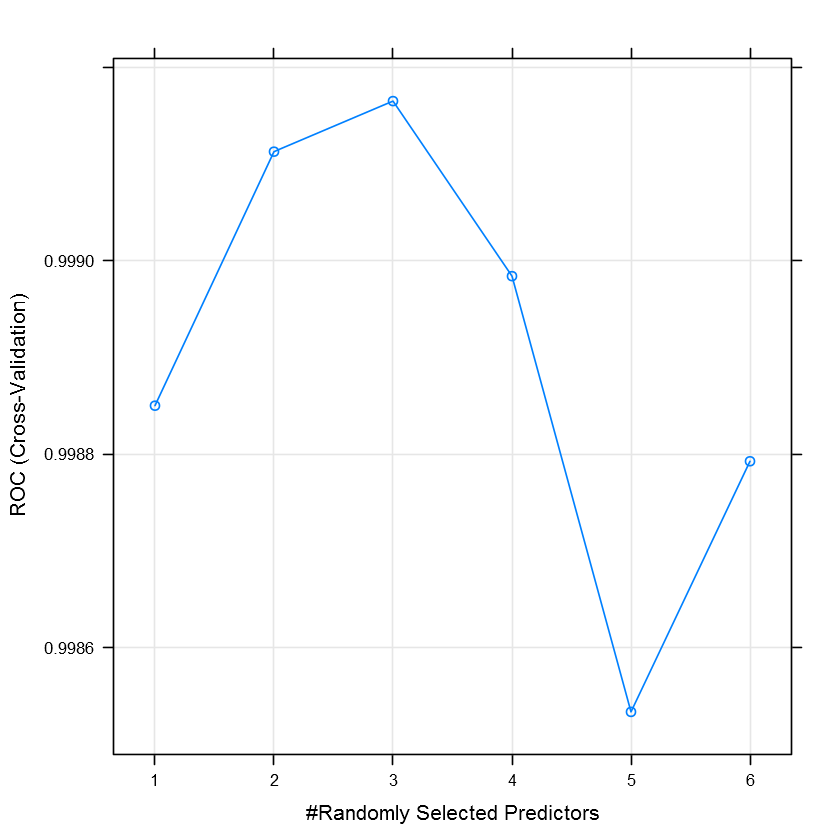

In [74]:
## Plot train tune
plot(rfTune)

In [75]:
## Test Set Results
rfPred <- predict(rfTune, testing, preProc = c("center", "scale"))
confusionMatrix(rfPred, testing$Class)

Confusion Matrix and Statistics

          Reference
Prediction white  red
     white  1464   13
     red       5  466
                                          
               Accuracy : 0.9908          
                 95% CI : (0.9854, 0.9945)
    No Information Rate : 0.7541          
    P-Value [Acc > NIR] : < 2e-16         
                                          
                  Kappa : 0.9749          
 Mcnemar's Test P-Value : 0.09896         
                                          
            Sensitivity : 0.9966          
            Specificity : 0.9729          
         Pos Pred Value : 0.9912          
         Neg Pred Value : 0.9894          
             Prevalence : 0.7541          
         Detection Rate : 0.7515          
   Detection Prevalence : 0.7582          
      Balanced Accuracy : 0.9847          
                                          
       'Positive' Class : white           
                                          

In [76]:
## Predicting Class Probabilities
rfProbs <- predict(rfTune, testing, preProc = c("center", "scale"), type = "prob")
head(rfProbs, 3)

,white,red
1,1,0
4,1,0
5,1,0


In [77]:
## variable importance
rf.imp = varImp ( rfTune , scale = F)
rf.imp

rf variable importance

                     Overall
total.sulfur.dioxide  550.16
chlorides             512.72
volatile.acidity      235.75
sulphates             119.08
residual.sugar         81.81
fixed.acidity          79.98
pH                     41.89
citric.acid            41.27
alcohol                19.31
quality                 5.49

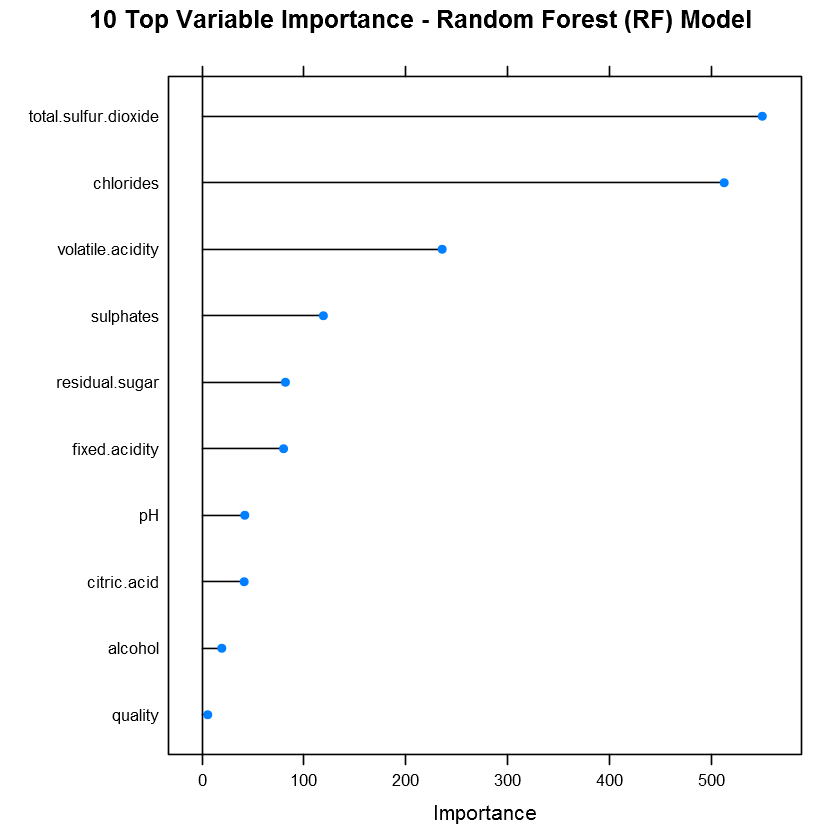

In [78]:
## Graphic variable importance
#dev.new()
plot(rf.imp, top=10, main="10 Top Variable Importance - Random Forest (RF) Model")

## V Selecting best model
 
I have considered nonlinear (CART, C5 BOOSTED TREE, SVM, KNN, and RF) algorithms. I reset the random number seed before each run to ensure that the evaluation of each algorithm is performed using exactly the same data splits. It ensures the results are directly comparable. 
 
We now have 5 models and we need to compare them to each other and select the one with better ROC metric performance.

The k-fold cross-validation method for the metrics was set in k=10. The following table presents the ROC metric measures across the 5 models.

In [79]:
#create comparative table ROC metrics each model
cvmetric1 <- c(round(mean(rpartTune$resample$ROC),6), round(mean(rpartTune$resample$Sens),4),round(mean(rpartTune$resample$Spec),4),round(sd(rpartTune$resample$ROC),4),round(sd(rpartTune$resample$Sens),4),round(sd(rpartTune$resample$Spec),4))

cvmetric2 <- c(round(mean(c5Tune$resample$ROC),6), round(mean(c5Tune$resample$Sens),4),round(mean(c5Tune$resample$Spec),4),round(sd(c5Tune$resample$ROC),4),round(sd(c5Tune$resample$Sens),4),round(sd(c5Tune$resample$Spec),4))

cvmetric3 <- c(round(mean(svmTune$resample$ROC),6), round(mean(svmTune$resample$Sens),4),round(mean(svmTune$resample$Spec),4),round(sd(svmTune$resample$ROC),4),round(sd(svmTune$resample$Sens),4),round(sd(svmTune$resample$Spec),4))

cvmetric4 <- c(round(mean(knnTune$resample$ROC),6), round(mean(knnTune$resample$Sens),4),round(mean(knnTune$resample$Spec),4),round(sd(knnTune$resample$ROC),4),round(sd(knnTune$resample$Sens),4),round(sd(knnTune$resample$Spec),4))

cvmetric5 <- c(round(mean(rfTune$resample$ROC),6), round(mean(rfTune$resample$Sens),4),round(mean(rfTune$resample$Spec),4),round(sd(rfTune$resample$ROC),4),round(sd(rfTune$resample$Sens),4),round(sd(rfTune$resample$Spec),4))

allcvmetrics <- rbind(CART=cvmetric1, c5Boost=cvmetric2, SVM=cvmetric3, KNN=cvmetric4, RF=cvmetric5) 

colnames(allcvmetrics) <- c("ROC","Sensitivity","Specificity","Sd(ROC)","Sd(Sensitivity)","Sd(Specificity)")
(allcvmetrics)


,ROC,Sensitivity,Specificity,Sd(ROC),Sd(Sensitivity),Sd(Specificity)
CART,0.987772,0.9843,0.9607,0.0078,0.0118,0.0134
c5Boost,0.998550,0.9947,0.9848,0.0020,0.0051,0.0119
SVM,0.999187,0.9971,0.9821,0.0010,0.0031,0.0133
KNN,0.997606,0.9936,0.9848,0.0039,0.0058,0.0127
RF,0.999165,0.9965,0.9848,0.0011,0.0045,0.0095


As a general appreciation, all models have very good ROC scores, but the best one corresponds to SVM (0.999187).

The following graph presents the ROC curves of each model got it through the testing dataset. So we can see the different ROC's shapes and which of the models has a bigger AUC associated metric. In our case, all models are under SVM curve meaning that SVM's model performs better even in the testing dataset too.


Type 'citation("pROC")' for a citation.

Attaching package: 'pROC'

The following objects are masked from 'package:stats':

    cov, smooth, var



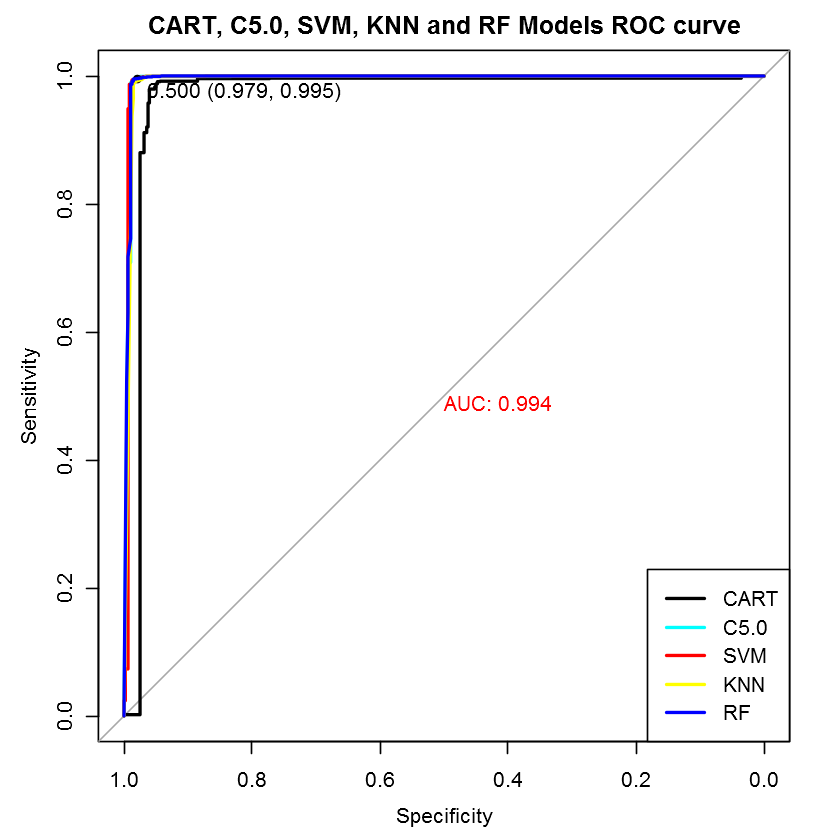

In [80]:
## Creating the ROC Curve
library(pROC)
rpartROC <- roc(predictor = rpartProbs$white, response = testing$Class, levels = rev(levels(testing$Class)))
c5ROC <- roc(predictor = c5Probs$white, response = testing$Class, levels = rev(levels(testing$Class)))
svmROC <- roc(predictor = svmProbs$white, response = testing$Class, levels = rev(levels(testing$Class)))
knnROC <- roc(predictor = knnProbs$white, response = testing$Class, levels = rev(levels(testing$Class)))
rfROC <- roc(predictor = rfProbs$white, response = testing$Class, levels = rev(levels(testing$Class)))


plot(rpartROC, type = "S", main="CART, C5.0, SVM, KNN and RF Models ROC curve")
plot(c5ROC, add = TRUE,  col = "cyan")
plot(svmROC, add = TRUE, print.thres = .5, col = "red", print.auc=TRUE)
plot(knnROC, add = TRUE, col = "yellow")
plot(rfROC, add = TRUE,  col = "blue")
legend("bottomright", legend = c("CART", "C5.0", "SVM", "KNN", "RF"), col = c("black", "cyan", "red", "yellow", "blue"),lwd = 2)

## VI Making predictions
 
The RF algorithm was chosen as the best model that we tested. Now we want to get the predictions from the model on our training dataset.

In [81]:
# print predictions probabilities by row
as.data.frame(svmProbs)

white,red
0.9999630,3.702439e-05
0.9997974,2.025978e-04
0.9997974,2.025978e-04
0.9993742,6.258465e-04
0.9993408,6.592085e-04
0.9999819,1.812371e-05
0.9999175,8.252847e-05
0.9998694,1.306194e-04
0.9998021,1.979045e-04
0.9999733,2.667042e-05


In [82]:
# print validation dataset and predictions by row
(val<-as.data.frame(c(testing,as.data.frame(svmPred))))

fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,total.sulfur.dioxide,pH,sulphates,alcohol,quality,Class,svmPred
7.0,0.270,0.36,17.55,0.045,170.0,3.00,0.45,8.8,6,white,white
7.2,0.230,0.32,8.50,0.058,186.0,3.19,0.40,9.9,6,white,white
7.2,0.230,0.32,8.50,0.058,186.0,3.19,0.40,9.9,6,white,white
8.1,0.280,0.40,6.90,0.050,97.0,3.26,0.44,10.1,6,white,white
6.2,0.655,0.48,1.20,0.029,75.0,3.33,0.39,12.8,8,white,white
6.5,0.310,0.14,7.50,0.044,133.0,3.22,0.50,9.5,5,white,white
6.8,0.260,0.42,1.70,0.049,122.0,3.47,0.48,10.5,8,white,white
6.6,0.270,0.41,1.30,0.052,142.0,3.42,0.47,10.0,6,white,white
7.2,0.320,0.36,2.00,0.033,114.0,3.10,0.71,12.3,7,white,white
6.2,0.120,0.34,1.50,0.045,117.0,3.42,0.51,9.0,6,white,white


Now if you want to get the predictions from a new test data, you can see the item 7.4 of my project [MACHINE LEARNING: A comparison of supervised learning algorithms applied to the classification problem with caret R-project library](http://nbviewer.jupyter.org/github/arqmain/Machine_Learning/blob/master/R_MLearning/MLearning_Classification_Comparison_R_Caret/MLearning_Classification_Comparison_R_Caret.ipynb). 

## VII Conclusion

This module of the project develops 5 algorithms of machine learning to classify the wines in white or red according to the 11 variables that characterize the wine subject to classification.

The database -dfffull- does not consider two variables that appear in the original base. They could generate a problem of multicollinearity in the process of classification. So,  we got rid of them in dfffull. At the same time, <u><b><i>dfffull</i></b></u> keep all the register of the original database "df" but replace the upper outliers by its corresponding <i>Threshold</i>. The application of this rule does not reduce the original data size because it does not eliminate any register. So, dfffull data size is the same as the original "df" (6497). 

The 5 models proposed achieve a very good metric of classification, reaching all a ROC measurement of at least 98%. That is, the variables of the base allow to discriminate clearly the type of wine that they represent.

The models were developed by tuning some or all of their parameters most of the time.  Anyway, this is modeling so, we can improve the models by filtering other variables, performing more tuning or doing both things at the same time.

<hr>
By: Hector Alvaro Rojas | Data Science, Visualizations and Applied Statistics | October 12, 2017<br>
Url: [http://www.arqmain.net]   &nbsp;&nbsp;&nbsp;|&nbsp;&nbsp;&nbsp;   GitHub: [https://github.com/arqmain]